In [1]:
%cd '/content/drive/MyDrive/Movie Rating Prediction/Movie Reviews Weighted Average'

/content/drive/MyDrive/Movie Rating Prediction/Movie Reviews Weighted Average


In [2]:
!nvidia-smi


Sat Jul  3 13:48:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers==2.11.0

     |████████████████████████████████| 675kB 9.1MB/s 
     |████████████████████████████████| 5.6MB 18.0MB/s 
     |████████████████████████████████| 1.2MB 47.0MB/s 
     |████████████████████████████████| 901kB 47.8MB/s 


In [4]:
!pip install -q -U watermark


In [5]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers


Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.9.0+cu102
transformers: 2.11.0



In [6]:
import transformers

from transformers import  XLNetModel, AdamW, get_linear_schedule_with_warmup , XLNetTokenizer

# from pytorch_transformers import  XLNetTokenizer #, XLNetForSequenceClassification , XLNetModel
# from pytorch_transformers import AdamW

import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [101]:
# Import dependencies
import json # reading in source file
import re # regular expressions
import time
import pandas as pd
# TODO Investigate "SettingWithCopyWarning" and refactor df assignments using .loc
pd.options.mode.chained_assignment = None

In [119]:
df = pd.read_csv('userReviews.csv')


In [120]:
df.shape

(37541, 6)

In [123]:
df.head()

,movie title,overall review,user_review,user_rating,Helpful Count,Total Count
0,The Dark Knight,9.0,Totally one of the greatest movie titles ever ...,10,48,51
1,The Dark Knight,9.0,Best movie ever. Heath ledger's work is phenom...,10,76,83
2,The Dark Knight,9.0,"Confidently directed, dark, brooding, and pack...",10,431,508
3,The Dark Knight,9.0,It is just what you want for the best movie. G...,10,193,226
4,The Dark Knight,9.0,I got to see The Dark Knight on Wednesday nigh...,10,938,"1,142"


In [124]:

import re
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

In [125]:
df['user_review'] = df['user_review'].apply(clean_text)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


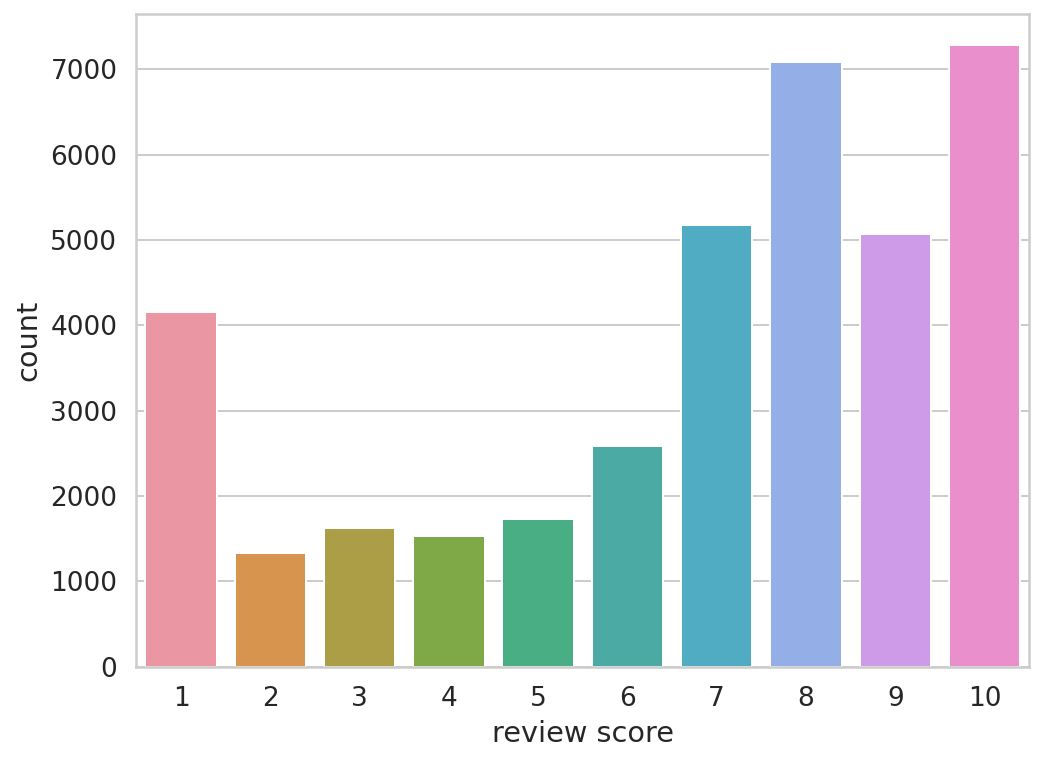

In [126]:
rcParams['figure.figsize'] = 8, 6
sns.countplot(df.user_rating)
plt.xlabel('review score');

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37541 entries, 0 to 37540
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie title     37541 non-null  object 
 1   overall review  37541 non-null  float64
 2   user_review     37541 non-null  object 
 3   user_rating     37541 non-null  int64  
 4   Helpful Count   37541 non-null  object 
 5   Total Count     37541 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.7+ MB


In [128]:
from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [129]:
input_txt = "India is my country. All Indians are my brothers and sisters"
encodings = tokenizer.encode_plus(input_txt, add_special_tokens=True, max_length=16, return_tensors='pt', return_token_type_ids=False, return_attention_mask=True, pad_to_max_length=False)

In [130]:
print('input_ids : ',encodings['input_ids'])


input_ids :  tensor([[ 837,   27,   94,  234,    9,  394, 7056,   41,   94, 4194,   21, 8301,
            4,    3]])


In [131]:
tokenizer.convert_ids_to_tokens(encodings['input_ids'][0])


['▁India',
 '▁is',
 '▁my',
 '▁country',
 '.',
 '▁All',
 '▁Indians',
 '▁are',
 '▁my',
 '▁brothers',
 '▁and',
 '▁sisters',
 '<sep>',
 '<cls>']

In [132]:
attention_mask = pad_sequences(encodings['attention_mask'], maxlen=512, dtype=torch.Tensor ,truncating="post",padding="post")


In [133]:

attention_mask = attention_mask.astype(dtype = 'int64')
attention_mask = torch.tensor(attention_mask) 
attention_mask.flatten()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [134]:
token_lens = []

for txt in df['user_review']:
  tokens = tokenizer.encode(txt, max_length=1024)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


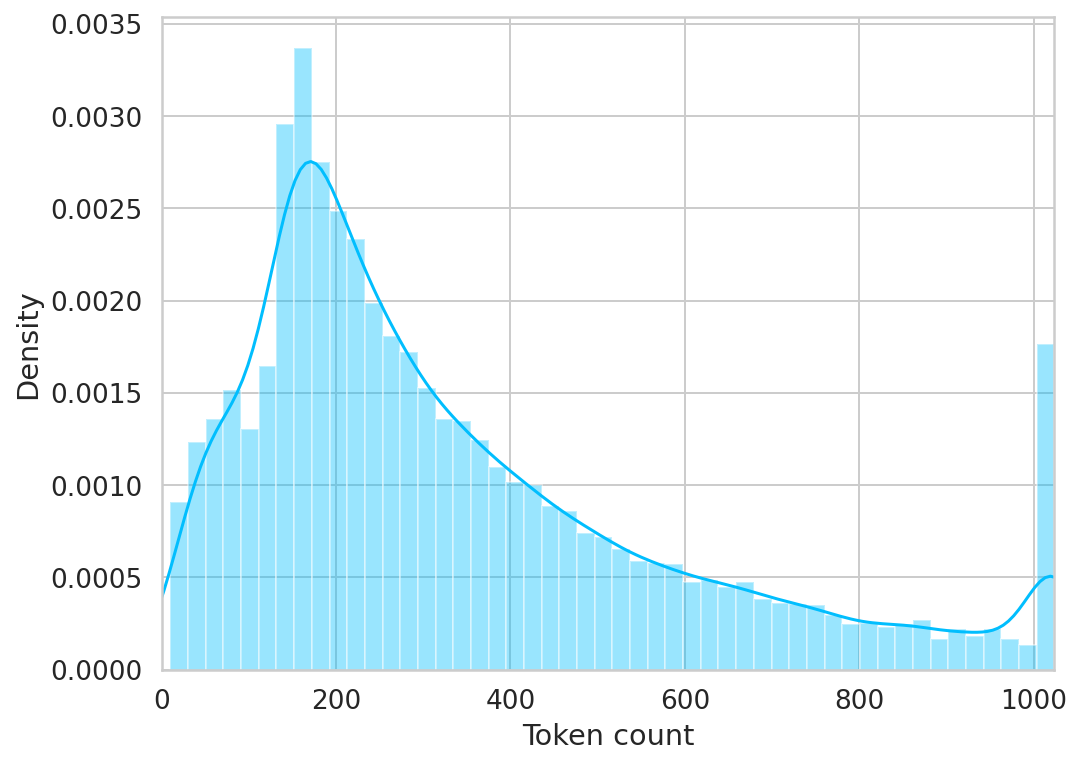

In [136]:
sns.distplot(token_lens)
plt.xlim([0, 1024]);
plt.xlabel('Token count');

In [137]:
MAX_LEN = 512


In [138]:
class ImdbDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'review_text': review,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.float)
        }

In [139]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ImdbDataset(
    reviews=df.user_review.to_numpy(),
    targets=df.user_rating.to_numpy(dtype = np.float64),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [140]:
BATCH_SIZE = 4

test_data_loader = create_data_loader(df, tokenizer, MAX_LEN, BATCH_SIZE)

In [141]:
from transformers import XLNetForSequenceClassification
from transformers import XLNetConfig


config = XLNetConfig.from_pretrained("xlnet-base-cased", num_labels=1)
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", config=config)

model.load_state_dict(torch.load('models/xlnet_model.bin'))


model = model.to(device)

In [142]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [143]:
data = next(iter(test_data_loader))
data.keys()


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [144]:
# *_  , ,last = iter(test_data_loader) # for a better understanding check PEP 448
# data = last
# data.keys()


In [145]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)
print(input_ids.reshape(4,512).shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 512])
torch.Size([4, 512])


In [146]:
outputs = model(input_ids.reshape(4,512), token_type_ids=None, attention_mask=attention_mask, labels=targets)

print(targets)
print('________________________________________________')
x , y = torch.max(outputs[1], dim=1)
y


tensor([10., 10., 10., 10.], device='cuda:0')
________________________________________________


tensor([0, 0, 0, 0], device='cuda:0')

In [147]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    counter = 0
    l = len(iter(data_loader))

    d = next(iter(test_data_loader))
    with torch.no_grad():
        for d in data_loader:
          if counter < l-1:

            texts = d["review_text"]
            input_ids = d["input_ids"].reshape(4,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

            loss = outputs[0]
            logits = outputs[1]
            
            preds, _ = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)
            counter = counter + 1

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [148]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [149]:
y_pred[:10]

tensor([1.0019, 0.9903, 0.8467, 0.9201, 0.9130, 0.8313, 0.8988, 0.9007, 0.9161,
        0.9890])

In [150]:
y_review_texts[11319]

"Highly intense and completely merciless this old school shocker from Australia is one for the hard core horror fans!Three youths driving across the outback get stranded and fall into the hands of a sadistic maniac.Reportedly based upon real life crimes Wolf Creek comes out as an already creepy venture and with the help of director Greg McLean this film becomes superior horror fare. McLean shows his flair for direction throughout the film giving it a neat documentary style look that adds greatly to the realistic feel that this film carries. He also adds some wonderful imagery that gives this film a kind of artistic quality that few horror movies ever have. The use of a subtle music score and the raw scenic beauty of the Australian countryside also contributes to the realism that McLean establishes. All of which sets us up for even more terror and suspense as our likable young characters meet with a horrifying situation. The story is believably written with an intriguing feeling of drea

In [151]:
df = df.loc[:len(df)-2]

In [152]:
df['pred_review_rating'] = y_pred

In [153]:
df.loc[5006 , 'user_review']

"I think there is a valid argument to make that the universal visceral impact that Funny Games has on audiences undermines the very thesis of its director Michael Haneke. I use the word thesis very deliberately because Funny Games is an intellectual academic statement. Plainly it is not an entertainment movie but I don't consider it to be an art film either. Haneke intended it to be neither in my opinion. I think he intended it as an assault on both Hollywood and the audience. It's the cinematic equivalent of punk. Rock music against rock music. This is an analogy Haneke draws the audience to himself by overriding the classical music Anna and Georg are listening to with some extreme punk music on the sound track. We are left in doubt that the world of Funny Games belongs to Peter and Paul. Anna and Georg and their bourgeois taste in music are treated with utter contempt before Peter and Paul even appear on the screen.Getting back to my original point I think there are two parts to Hane

In [154]:
df.to_csv('UserReviewWithReviewRating.csv', index = False)

In [155]:
temp = pd.read_csv('UserReviewWithReviewRating.csv')

In [156]:
print(temp.pred_review_rating.mean())
temp.user_rating.mean()

0.608964776681468


6.745311667554608

In [157]:
temp.head()

,movie title,overall review,user_review,user_rating,Helpful Count,Total Count,pred_review_rating
0,The Dark Knight,9.0,Totally one of the greatest movie titles ever ...,10,48,51,1.001919
1,The Dark Knight,9.0,Best movie ever. Heath ledger's work is phenom...,10,76,83,0.990340
2,The Dark Knight,9.0,Confidently directed dark brooding and packed ...,10,431,508,0.846666
3,The Dark Knight,9.0,It is just what you want for the best movie. G...,10,193,226,0.920118
4,The Dark Knight,9.0,I got to see The Dark Knight on Wednesday nigh...,10,938,"1,142",0.912978
